In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score
import dataframe_image as dfi

## Data Preparation

In [39]:
#Read in Data:
mental_health = pd.read_csv('mental_health.csv')

## Feature Engineering

In [40]:
#Data Cleaning:
cols = ['1. Age', '2. Gender', '3. University', '4. Department','5. Academic Year', '6. Current CGPA',
        '7. Did you receive a waiver or scholarship at your university?', 'Anxiety Value', 'Stress Value'
        ,'Depression Value']
_mental_health = mental_health.copy()
cleaned_mental_health = _mental_health[cols]
#Dropped lots of redundant and useless columns.
cleaned_mental_health = cleaned_mental_health.drop_duplicates()
cleaned_mental_health.isnull().sum()
#There are no missing values
cleaned_mental_health.columns

Index(['1. Age', '2. Gender', '3. University', '4. Department',
       '5. Academic Year', '6. Current CGPA',
       '7. Did you receive a waiver or scholarship at your university?',
       'Anxiety Value', 'Stress Value', 'Depression Value'],
      dtype='object')

In [41]:
#One Hot Encoding:
numeric_cols = cleaned_mental_health.select_dtypes(include=['number']).columns
cleaned_mental_health[numeric_cols] = cleaned_mental_health[numeric_cols].apply(pd.to_numeric, errors='coerce')
cleaned_mental_health = pd.get_dummies(cleaned_mental_health , drop_first=True)
cleaned_mental_health = cleaned_mental_health.astype(int)
cleaned_mental_health.head()
cleaned_mental_health.shape
cleaned_mental_health.columns

Index(['Anxiety Value', 'Stress Value', 'Depression Value', '1. Age_23-26',
       '1. Age_27-30', '1. Age_Above 30', '1. Age_Below 18', '2. Gender_Male',
       '2. Gender_Prefer not to say', '3. University_BRAC University',
       '3. University_Bangladesh Agricultural University (BAU)',
       '3. University_Bangladesh University of Engineering and Technology (BUET)',
       '3. University_Daffodil University',
       '3. University_Dhaka University (DU)',
       '3. University_Dhaka University of Engineering and Technology (DUET)',
       '3. University_East West University (EWU)',
       '3. University_Independent University, Bangladesh (IUB)',
       '3. University_Islamic University of Technology (IUT)',
       '3. University_North South University (NSU)',
       '3. University_Patuakhali Science and Technology University',
       '3. University_Rajshahi University (RU)',
       '3. University_Rajshahi University of Engineering and Technology (RUET)',
       '3. University_Unite

In [42]:
#Mental Health Score:
cleaned_mental_health['Mental_Health_Score'] = (0.25 * cleaned_mental_health['Stress Value']) + (0.35 * cleaned_mental_health['Anxiety Value']) + (0.4 * cleaned_mental_health['Depression Value'])
#Stress can have both positive and negative aspects thus, it is less important and has a lower weight.
#Anxiety is the most common academic symptom I hear about therefore it gets a higher weight.
#Depression is the most harming and detrimental symptom therefore it has the highest wieght.
#These weights are completely theoretical and can be adjusted.

## Data Splitting

In [43]:
#Data Splitting: Cross Validation
X = cleaned_mental_health.drop(columns=['Mental_Health_Score'])
y = cleaned_mental_health['Mental_Health_Score']
#Seperated all features from what we want to observe
degrees = [1, 2, 3, 4]
kf = KFold(n_splits=4, shuffle=True, random_state=42)
#Chose 5 folds for data

## Regression Task

In [44]:
#Polynomial Model:
n_components = 13
degree_errors = {}

for degree in degrees:
    model = Pipeline([('scaler', StandardScaler())                 #Normalize
                      ,('poly', PolynomialFeatures(degree=degree)) #Polynomial Transformation
                      ,('regressor', LinearRegression())])         #Linear Regression
                      #We used PCA in order to reduce the dimensionality of our model to avoid the kernel breaking
    #Averaging Across Folds:
    mse_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    mse_avg = -mse_scores.mean()
    degree_errors[degree] = mse_avg
#('pca', PCA(n_components=n_components)) 

{1: np.float64(4.6655526931087607e-29), 2: np.float64(0.5677590865367936), 3: np.float64(0.21732732296449594), 4: np.float64(0.6274460913756512)}


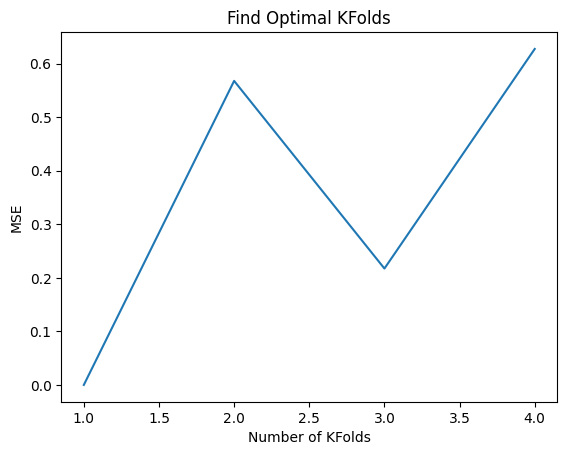

In [45]:
#Finding Optimal Degree
print(degree_errors)
num_kfold,mse_plot = zip(*degree_errors.items())
plt.plot(num_kfold,mse_plot)
plt.title('Find Optimal KFolds')
plt.xlabel('Number of KFolds')
plt.ylabel('MSE')
plt.savefig('Math 483 Project 2 K-Folds')

In [46]:
#Running Polynomial Regression on Data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Decided to split data 80/20 rather than cross-validation
model_1 = Pipeline([('scaler', StandardScaler())           #Normalize
                      ,('poly', PolynomialFeatures(degree=1)) #Polynomial Transformation with degree of least MSE
                      ,('regressor', LinearRegression())])    #Linear Regression
model_1.fit(X_train, y_train)
y_pred_1 = model_1.predict(X_test)
#Applied data to linear model

model_2 = Pipeline([('scaler', StandardScaler())           #Normalize
                      ,('poly', PolynomialFeatures(degree=2)) #Polynomial Transformation with degree of least MSE
                      ,('regressor', LinearRegression())])    #Linear Regression
model_2.fit(X_train, y_train)
y_pred_2 = model_2.predict(X_test)
#Applied data to quadratic model

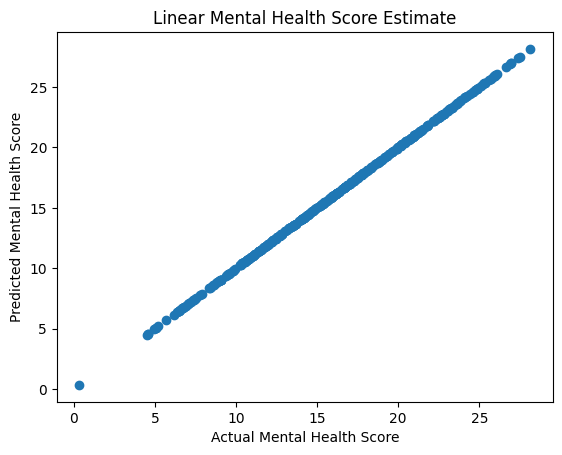

In [47]:
plt.scatter(y_test , y_pred_1)
plt.xlabel('Actual Mental Health Score')
plt.ylabel('Predicted Mental Health Score')
plt.title('Linear Mental Health Score Estimate')
plt.savefig('Math 483 Project 2 Linear Health Prediction')

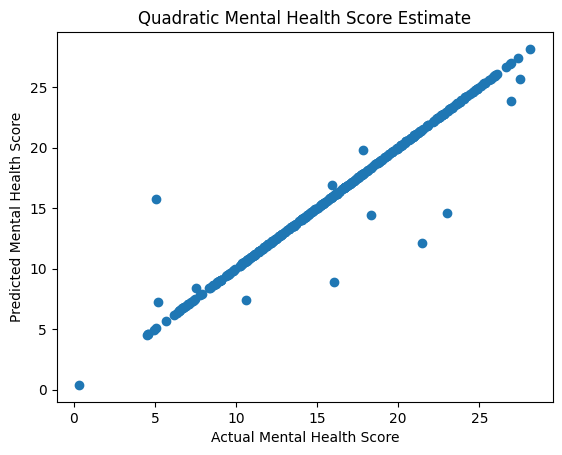

In [48]:
plt.scatter(y_test , y_pred_2)
plt.xlabel('Actual Mental Health Score')
plt.ylabel('Predicted Mental Health Score')
plt.title('Quadratic Mental Health Score Estimate')
plt.savefig('Math 483 Project 2 Quadratic Health Prediction')

In [49]:
#Training Learning Curve for Linear Model:
train_sizes, train_scores, valid_scores = learning_curve(
LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1, 100),
scoring="neg_root_mean_squared_error")

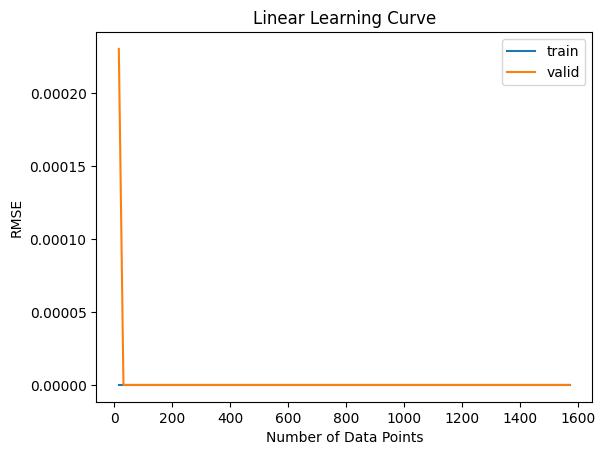

In [50]:
#Graphing Learning Curve:
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)
plt.plot(train_sizes, train_errors, label="train")
plt.plot(train_sizes, valid_errors, label="valid")
plt.ylabel('RMSE')
plt.xlabel('Number of Data Points')
plt.title('Linear Learning Curve')
plt.legend()
plt.savefig('Math 483 Project 2 Linear Regression Optimizer')
#This model will not improve with more data. From the graph we see that the RMSE drops off very quickly after 30 data points.

In [51]:
#Training Learning Curve for Quadratic Model
polynomial_regression = make_pipeline(
PolynomialFeatures(degree=2, include_bias=False),LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40),
scoring="neg_root_mean_squared_error")

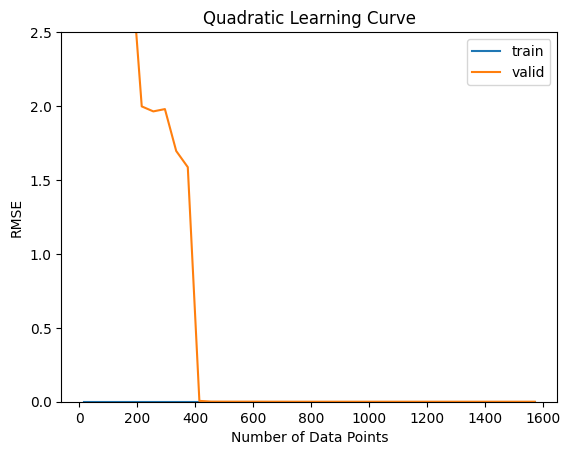

In [52]:
#Graphing Quadratic Learning Curve
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)
plt.plot(train_sizes, train_errors, label="train")
plt.plot(train_sizes, valid_errors, label="valid")
plt.title('Quadratic Learning Curve')
plt.xlabel('Number of Data Points')
plt.ylabel('RMSE')
plt.ylim((0,2.5))
plt.legend()
plt.savefig('Math 483 Project 2 Quadratic Regression Optimizer')
#The results of our model do not recieve much improvment after 400 data points.

In [53]:
#Finding Most Important Features in Linear Model
coef_1 = model_1.named_steps['regressor'].coef_
feature_importance_1 = dict(zip(cleaned_mental_health.columns , coef_1))
#Shifting Coefficients Backwards
keys_1 = list(feature_importance_1.keys())
values_1 = list(feature_importance_1.values())
shifted_values_1 = values_1[1:] + values_1[:1]
feature_importance_1 = {keys_1[i]: shifted_values_1[i] for i in range(len(keys_1))}
#Sort Values
feature_importance_1 = pd.DataFrame(list(feature_importance_1.items()), columns=['Feature', 'Importance'])
feature_importance_1 = feature_importance_1.sort_values(by='Importance' , ascending=False).reset_index(drop=True)

#Find First 5 Features
feature_importance_1[:5]

,Feature,Importance
0,Depression Value,2.672356e+00
1,Anxiety Value,1.942713e+00
2,Stress Value,1.691653e+00
3,4. Department_Pharmacy and Public Health,9.540979e-16
4,5. Academic Year_Third Year or Equivalent,9.436896e-16


In [54]:
#Finding Most Important Features in Quadratic Model
coef_2 = model_2.named_steps['regressor'].coef_
feature_importance_2 = dict(zip(cleaned_mental_health.columns , coef_2))
#Shifting Coefficients Backwards
keys_2 = list(feature_importance_2.keys())
values_2 = list(feature_importance_2.values())
shifted_values_2 = values_2[1:] + values_2[:1]
feature_importance_2 = {keys_2[i]: shifted_values_2[i] for i in range(len(keys_2))}
#Sort Values
feature_importance_2 = pd.DataFrame(list(feature_importance_2.items()), columns=['Feature', 'Importance'])
feature_importance_2 = feature_importance_2.sort_values(by='Importance' , ascending=False).reset_index(drop=True)

#Find First 5 Features
feature_importance_2[:5]

,Feature,Importance
0,Depression Value,2.628149
1,Anxiety Value,1.915332
2,Stress Value,1.664830
3,5. Academic Year_Third Year or Equivalent,0.002204
4,"3. University_Independent University, Banglade...",0.000810


## Classification Task

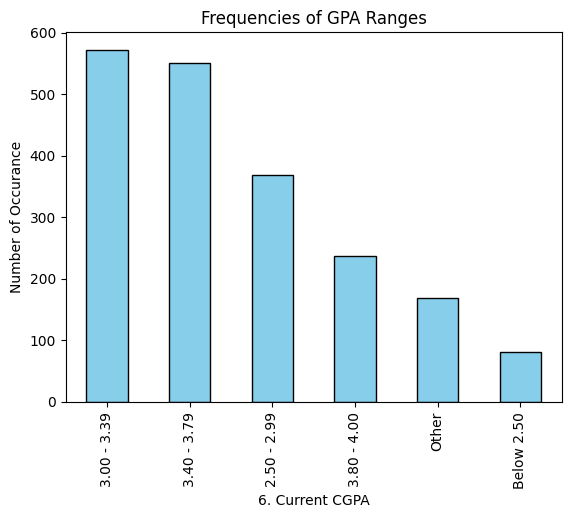

In [55]:
#Plotting the GPA's to understand the distribution.
value_counts = mental_health['6. Current CGPA'].value_counts()
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequencies of GPA Ranges')
plt.ylabel('Number of Occurance')
plt.savefig('Math 483 Project 2 GPA Frequency')

In [56]:
class_mental_health =_mental_health[cols]
#Took out 'Other' category as it provides us no information.
class_mental_health = class_mental_health[class_mental_health['6. Current CGPA'] != 'Other'].reset_index(drop=True)
print(class_mental_health['6. Current CGPA'].value_counts())
i=0
for c in class_mental_health['6. Current CGPA']:
    i += 1
print(i)
print(class_mental_health.shape)

6. Current CGPA
3.00 - 3.39    572
3.40 - 3.79    551
2.50 - 2.99    368
3.80 - 4.00    237
Below 2.50      81
Name: count, dtype: int64
1809
(1809, 10)


In [57]:
#Make copy of original dataset with only important features for manipulation.
class_mental_health =_mental_health[cols]
#Took out 'Other' category as it provides us no information.
class_mental_health = class_mental_health[class_mental_health['6. Current CGPA'] != 'Other'].reset_index(drop=True)
#Redoing range to get float type in uniform distribution.
unique_value = class_mental_health['6. Current CGPA'].value_counts()
scale_1 = np.linspace(0,2.5,unique_value['Below 2.50'])
scale_2 = np.linspace(0,0.49,unique_value['2.50 - 2.99']) + 2.5
scale_3 = np.linspace(0,0.39,unique_value['3.00 - 3.39']) + 3
scale_4 = np.linspace(0,0.39,unique_value['3.40 - 3.79']) + 3.4
scale_5 = np.linspace(0,0.2,unique_value['3.80 - 4.00']) + 3.8
n1,n2,n3,n4,n5 = 0,0,0,0,0
i = 0
for i in range(len(class_mental_health)):
    c = class_mental_health.loc[i, '6. Current CGPA']
    if c == 'Below 2.50':
        class_mental_health.loc[i,'6. Current CGPA'] = scale_1[n1]
        n1 +=1
        i += 1
    if c == '2.50 - 2.99':
        class_mental_health.loc[i,'6. Current CGPA'] = scale_2[n2]
        n2 +=1
        i += 1
    if c == '3.00 - 3.39':
        class_mental_health.loc[i,'6. Current CGPA'] = scale_3[n3]
        n3 +=1
        i += 1
    if c == '3.40 - 3.79':
        class_mental_health.loc[i,'6. Current CGPA'] = scale_4[n4]
        n4 +=1
        i += 1
    if c == '3.80 - 4.00':
        class_mental_health.loc[i,'6. Current CGPA'] = scale_5[n5]
        n5 +=1
        i += 1

In [58]:
#Creating threshold assuming that above median is good and below median is bad.
threshold = class_mental_health['6. Current CGPA'].median()
class_mental_health['Good GPA'] = np.where(class_mental_health['6. Current CGPA'] >= threshold, 1, 0)

In [59]:
#Setting Up My Linear Classifier in 2D
X = class_mental_health[['Depression Value','Anxiety Value']]
y = class_mental_health['Good GPA']
#Set up Variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Partition training and testing data.
grade_linear_model_2D = SGDClassifier(loss="hinge" , penalty='elasticnet', max_iter=500)
grade_linear_model_2D.fit(X_train,y_train)
pred_linear_grade_2D = grade_linear_model_2D.predict(X_test)


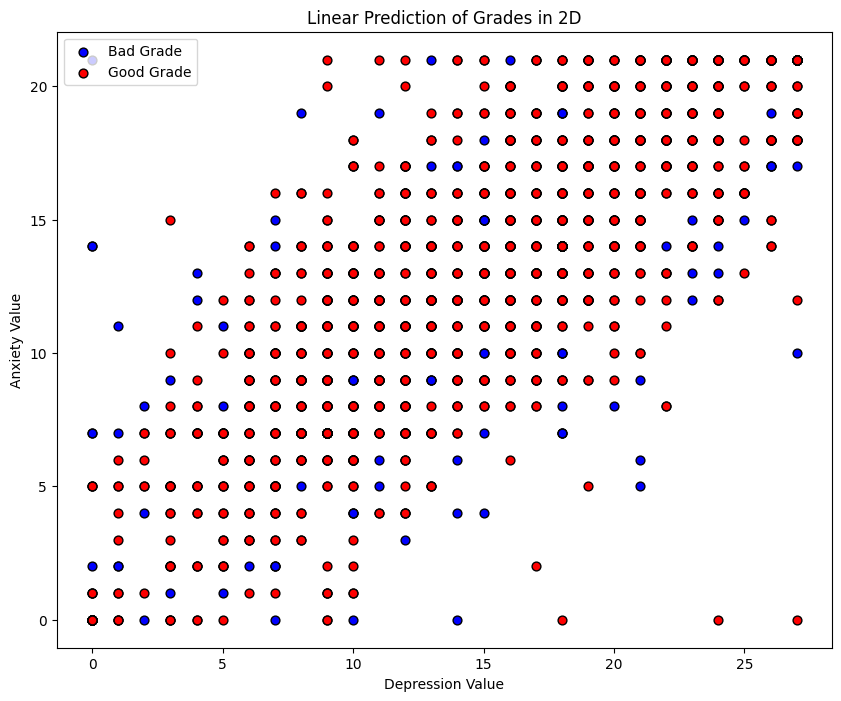

In [60]:
#Plotting the Linear Classifier in 2D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.scatter(X_train[y_train == 0].iloc[:, 0], X_train[y_train == 0].iloc[:, 1], color='blue', label='Bad Grade', edgecolor='k', s=40)
ax.scatter(X_train[y_train == 1].iloc[:, 0], X_train[y_train == 1].iloc[:, 1], color='red', label='Good Grade', edgecolor='k', s=40)
ax.set_xlabel('Depression Value')
ax.set_ylabel('Anxiety Value')
ax.set_title('Linear Prediction of Grades in 2D')
plt.legend()
plt.savefig('Math 483 Project 2 Linear 2D Grade')

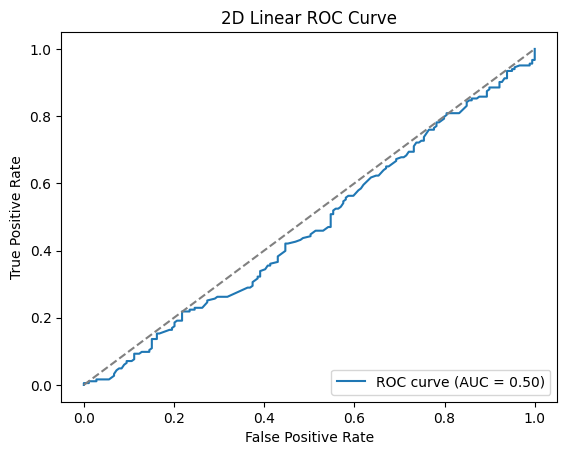

In [61]:
#ROC Curve for Linear Classifier in 2D
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
sgd_model = SGDClassifier(loss='log_loss', max_iter=1000, alpha=0.001, tol=1e-3, class_weight='balanced')
calibrated_model = CalibratedClassifierCV(sgd_model, cv=5)
calibrated_model.fit(X_train, y_train)
y_scores = calibrated_model.predict_proba(X_test)[:, 1]
#Use the best threshold for the model
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
j_scores = tpr - fpr
best_threshold = thresholds[j_scores.argmax()]
y_pred = (y_scores >= best_threshold).astype(int)
auc = roc_auc_score(y_test, y_pred)
#Plotting the Graph
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('2D Linear ROC Curve')
plt.savefig('Math 483 Project 2 Linear 2D Grade ROC')

In [62]:
#Finding Best Threshold and F1 Score
f1_scores = []
for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
#Finding Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
#Printing Values
print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Best Threshold: 0.4547415544423591
Best F1 Score: 0.671559633027523
Precision: 0.505524861878453
Recall: 1.0


In [63]:
#Setting Up My Linear Classifier in 3D
X = class_mental_health[['Depression Value','Anxiety Value','Stress Value']]
y = class_mental_health['Good GPA']
#Set up Variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Partition training and testing data.
grade_linear_model_3D = SGDClassifier(loss="hinge" , penalty='elasticnet', max_iter=500)
grade_linear_model_3D.fit(X_train,y_train)
pred_linear_grade_3D = grade_linear_model_3D.predict(X_test)

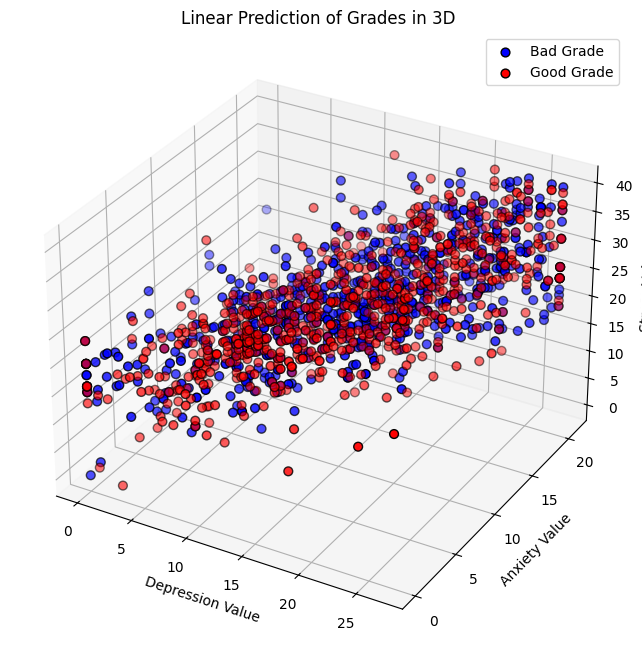

In [64]:
#Plotting the Linear Classifier in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[y_train == 0].iloc[:, 0], X_train[y_train == 0].iloc[:, 1], X_train[y_train == 0].iloc[:, 2],color='blue', label='Bad Grade', edgecolor='k', s=40)
ax.scatter(X_train[y_train == 1].iloc[:, 0], X_train[y_train == 1].iloc[:, 1], X_train[y_train == 1].iloc[:, 2],color='red', label='Good Grade', edgecolor='k', s=40)
ax.set_xlabel('Depression Value')
ax.set_ylabel('Anxiety Value')
ax.set_zlabel('Stress Value')
ax.set_title('Linear Prediction of Grades in 3D')
plt.legend()
plt.savefig('Math 483 Project 2 Linear 3D Grade')

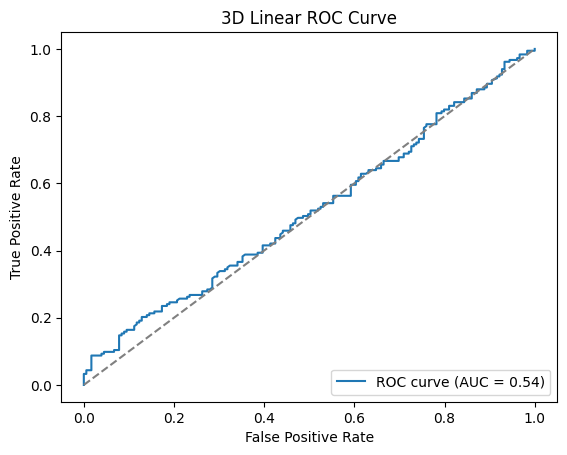

In [65]:
#ROC Curve for Linear Classifier in 3D
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
sgd_model = SGDClassifier(loss='log_loss', max_iter=1000, alpha=0.001, tol=1e-3, class_weight='balanced')
calibrated_model = CalibratedClassifierCV(sgd_model, cv=5)
calibrated_model.fit(X_train, y_train)
y_scores = calibrated_model.predict_proba(X_test)[:, 1]
#Use the best threshold for the model
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
j_scores = tpr - fpr
best_threshold = thresholds[j_scores.argmax()]
y_pred = (y_scores >= best_threshold).astype(int)
auc = roc_auc_score(y_test, y_pred)
#Plotting the Graph
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('3D Linear ROC Curve')
plt.savefig('Math 483 Project 2 Linear 3D Grade ROC')

In [66]:
#Finding Best Threshold and F1 Score
f1_scores = []
for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
#Finding Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
#Printing Values
print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Best Threshold: 0.4745702096098817
Best F1 Score: 0.6728280961182994
Precision: 0.505524861878453
Recall: 1.0


In [67]:
#Setting Up My Logistic Classifier for 2D
X = class_mental_health[['Depression Value','Anxiety Value']]
y = class_mental_health['Good GPA']
#Set up Variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Partition training and testing data.
grade_log_model_2D = SGDClassifier(loss="log_loss" , penalty='elasticnet', max_iter=500)
grade_log_model_2D.fit(X_train,y_train)
pred_log_grade_2D = grade_log_model_2D.predict(X_test)

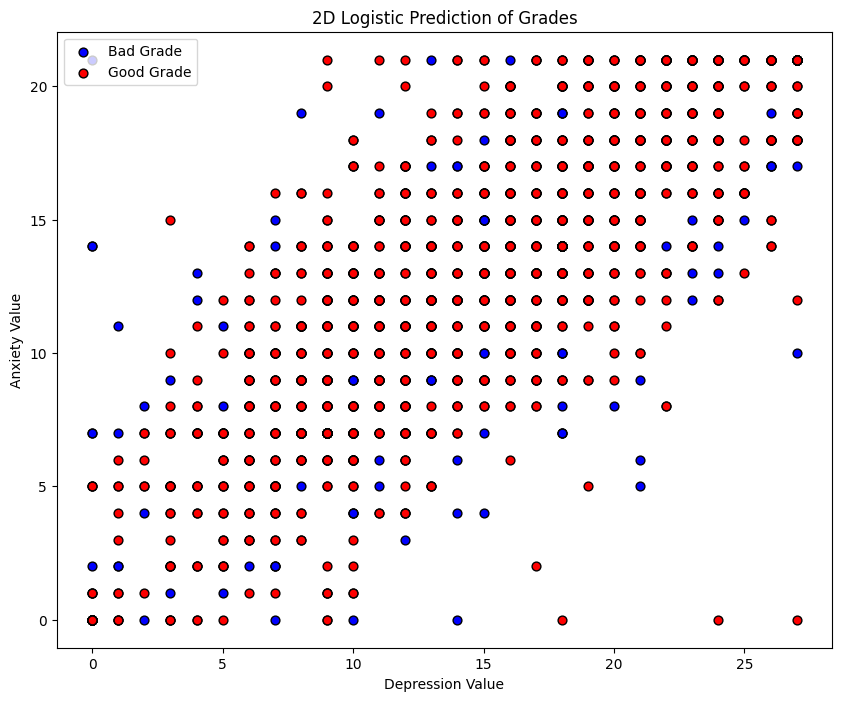

In [68]:
#Plotting the Logistic Classifier in 2D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.scatter(X_train[y_train == 0].iloc[:, 0], X_train[y_train == 0].iloc[:, 1], color='blue', label='Bad Grade', edgecolor='k', s=40)
ax.scatter(X_train[y_train == 1].iloc[:, 0], X_train[y_train == 1].iloc[:, 1], color='red', label='Good Grade', edgecolor='k', s=40)
ax.set_xlabel('Depression Value')
ax.set_ylabel('Anxiety Value')
ax.set_title('2D Logistic Prediction of Grades')
plt.legend()
plt.savefig('Math 483 Project 2 Logistic 2D Grade')

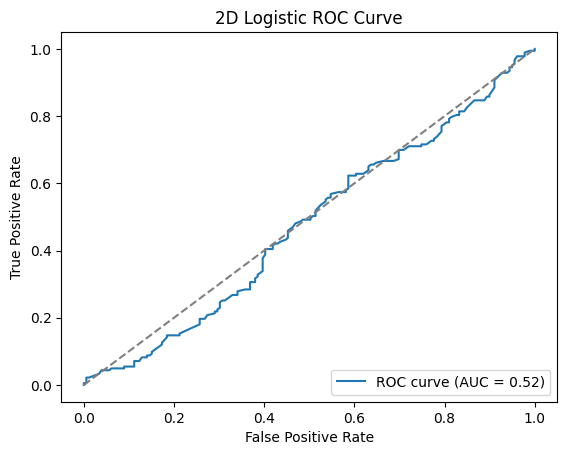

In [69]:
#ROC Curve for Logistic Classifier in 2D
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
sgd_model = SGDClassifier(loss='log_loss', max_iter=1000, alpha=0.001, tol=1e-3, class_weight='balanced')
calibrated_model = CalibratedClassifierCV(sgd_model, cv=5)
calibrated_model.fit(X_train, y_train)
y_scores = calibrated_model.predict_proba(X_test)[:, 1]
#Use the best threshold for the model
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
j_scores = tpr - fpr
best_threshold = thresholds[j_scores.argmax()]
y_pred = (y_scores >= best_threshold).astype(int)
auc = roc_auc_score(y_test, y_pred)
#Plotting the Graph
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('2D Logistic ROC Curve')
plt.savefig('Math 483 Project 2 Logistic 2D Grade ROC')

In [70]:
#Finding Best Threshold and F1 Score
f1_scores = []
for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
#Finding Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
#Printing Values
print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Best Threshold: 0.4680839176114482
Best F1 Score: 0.6716141001855288
Precision: 0.505524861878453
Recall: 1.0


In [71]:
#Setting Up My Logistic Classifier for 3D
X = class_mental_health[['Depression Value','Anxiety Value','Stress Value']]
y = class_mental_health['Good GPA']
#Set up Variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Partition training and testing data.
grade_log_model_3D = SGDClassifier(loss="log_loss" , penalty='elasticnet', max_iter=500)
grade_log_model_3D.fit(X_train,y_train)
pred_log_grade_3D = grade_log_model_3D.predict(X_test)

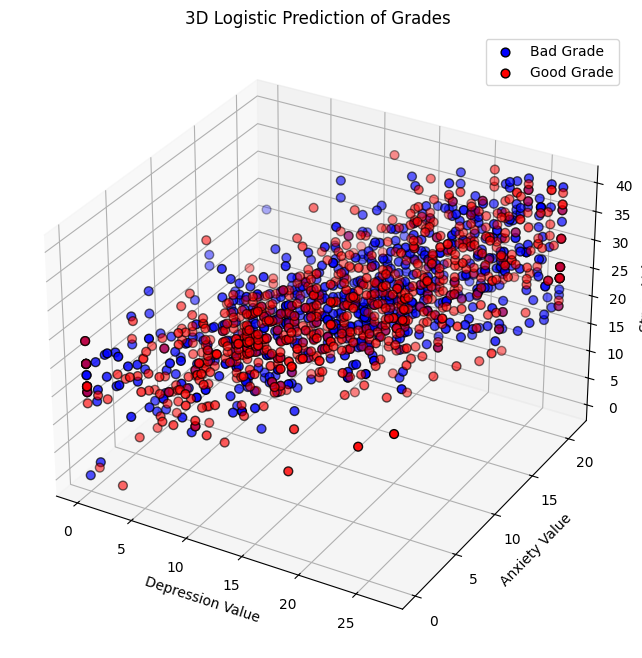

In [72]:
#Plotting the Logistic Classifier in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[y_train == 0].iloc[:, 0], X_train[y_train == 0].iloc[:, 1], X_train[y_train == 0].iloc[:, 2],color='blue', label='Bad Grade', edgecolor='k', s=40)
ax.scatter(X_train[y_train == 1].iloc[:, 0], X_train[y_train == 1].iloc[:, 1], X_train[y_train == 1].iloc[:, 2],color='red', label='Good Grade', edgecolor='k', s=40)
ax.set_xlabel('Depression Value')
ax.set_ylabel('Anxiety Value')
ax.set_zlabel('Stress Value')
ax.set_title('3D Logistic Prediction of Grades')
plt.legend()
plt.savefig('Math 483 Project 2 Logistic 3D Grade')

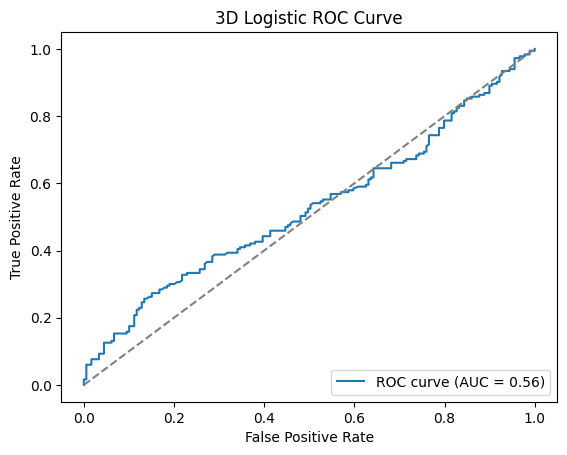

In [73]:
#ROC Curve for Logistic Classifier in 3D
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
sgd_model = SGDClassifier(loss='log_loss', max_iter=1000, alpha=0.001, tol=1e-3, class_weight='balanced')
calibrated_model = CalibratedClassifierCV(sgd_model, cv=5)
calibrated_model.fit(X_train, y_train)
y_scores = calibrated_model.predict_proba(X_test)[:, 1]
#Use the best threshold for the model
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
j_scores = tpr - fpr
best_threshold = thresholds[j_scores.argmax()]
y_pred = (y_scores >= best_threshold).astype(int)
auc = roc_auc_score(y_test, y_pred)
#Plotting the Graph
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('3D Logistic ROC Curve')
plt.savefig('Math 483 Project 2 Logistic 3D Grade ROC')

In [74]:
#Finding Best Threshold and F1 Score
f1_scores = []
for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)
    
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
#Finding Precision and Recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
#Printing Values
print(f'Best Threshold: {best_threshold}')
print(f'Best F1 Score: {best_f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

Best Threshold: 0.4789227487377371
Best F1 Score: 0.6715867158671587
Precision: 0.505524861878453
Recall: 1.0
